# Stochastic Gradient Descent (SGD)

In [20]:
%matplotlib inline
import math,sys,os,numpy as np
import torch
from matplotlib import pyplot as plt, rcParams, animation, rc
from __future__ import print_function, division
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3
%precision 4
np.set_printoptions(precision=4, linewidth=100)

### Linear Regression problem

The goal of linear regression is to fit a line to a set of points.

In [218]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

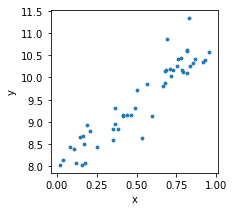

In [219]:
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y"); 

You want to find *parameters* (weights) $a$ and $b$ such that you minimize the *error* between the points and the line $a\cdot x + b$. Note that here $a$ and $b$ are unknown. For a regression problem the most common *error function* or *lost function* is the **mean squared error**. 

In [90]:
def mean_square_error(y_hat, y):
    """ Returns the mean square error.
    """
    return np.power(y_hat - y, 2).sum()/y.shape[0]

Suppose we believe $a = 10$ and $b = 5$ then we can compute `y_hat` which is our *prediction* and then compute our error.

In [87]:
y_hat =  lin(10,5,x)

mean_square_error(y_hat, y)

3.7165

In [91]:
def mean_square_error_loss(a, b, x, y):
    """ Returns the mean square error.
    """
    # computes a prediction based on a, and b
    y_hat =  lin(a,b,x)
    return np.power(y_hat - y, 2).sum()/y.shape[0]

In [92]:
mean_square_error_loss(10, 5, x, y)

3.7165

How do we find the best values for $a$ and $b$? 

### Gradient Descent

For a fixed dataset $x$ and $y$ `mean_square_error_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in pytorch

In [251]:
# generate some more data
x, y = gen_fake_data(1000, 3., 8.)

In [252]:
dtype = torch.cuda.FloatTensor

In [253]:
# from numpy to pytorch
x = torch.from_numpy(x)
y = torch.from_numpy(y)

In [254]:
from torch.autograd import Variable
# Create random Tensors to hold x and y, and wrap them in Variables.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Variables.
x = Variable(x.type(dtype), requires_grad=False)
y = Variable(y.type(dtype), requires_grad=False)

In [255]:
# Create random Tensors for weights a and b, and wrap them in Variables.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Variables.
a = Variable(torch.randn(1).type(dtype), requires_grad=True)
b = Variable(torch.randn(1).type(dtype), requires_grad=True)

In [256]:
print(a, b)

Variable containing:
1.00000e-03 *
 -5.4515
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.4145
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [257]:
learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y using operations on Variables
    y_pred = x.mul(a) + b
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 0:
        print(loss.data/n)
    
    # Manually zero the gradients
    if a.grad is not None:
        if a.grad.volatile:
            a.grad.data.zero_()
            b.grad.data.zero_()    
        else:
            data = a.grad.data
            a.grad = Variable(data.new().resize_as_(data).zero_())
            data = b.grad.data
            b.grad = Variable(data.new().resize_as_(data).zero_())
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively.
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are
    # Tensors.
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data


 83.5262
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  9.0736
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  8.5814
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  8.5434
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  8.5404
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [258]:
print(a, b)

Variable containing:
 2.9561
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 7.9919
[torch.cuda.FloatTensor of size 1 (GPU 0)]



### Stochastic gradient descent (SGD)

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent(SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

### Visualizing gradient descent

In [235]:
x, y = gen_fake_data(50, 3., 8.)

In [236]:
def sse(y,y_pred): return ((y-y_pred)**2).sum()
def loss(y,a,b,x): return sse(y, lin(a,b,x))
def avg_loss(y,a,b,x): return np.sqrt(loss(y,a,b,x)/n)

In [237]:
a_guess=-1.
b_guess=1.
avg_loss(y, a_guess, b_guess, x)

1.9979

In [238]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(30): upd()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 40), interval=100)
ani